In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [ ]:
from clustering.utils import *

# Experiments

In [ ]:
restart_experiments = True
n_iterations = 4
methods = ['gmm_full', 'gmm_tied', 'gmm_diag', 'gmm_spherical', 'kmeans']
list_n_cluster = np.arange(2,8,1)
random_seeds = np.random.randint(high=200, low=1, size=n_iterations)
random_seeds

array([64, 43, 65, 12])

In [ ]:
#dict_results[Iteration]['Method'][Cluster_number]['Score']
if restart_experiments:
  # Create Empty Dictionary
  dict_results = {}
  for i in np.arange(n_iterations):
    dict_results_iteration = {}
    for method in methods:
      dict_temp = {}
      for n_cluster in list_n_cluster:
        dict_entry = {'silhouette_score': np.nan, 'ch_score': np.nan, 'db_score': np.nan, 'model_specific_score': np.nan}
        dict_temp.update({n_cluster:dict_entry})
      dict_results_iteration.update({method: dict_temp})
    dict_results.update({i:dict_results_iteration})

In [ ]:
if restart_experiments:
  cov_type='full'
  # Experiments
  for i in np.arange(n_iterations):
    random_seed = random_seeds[i]
    for method in methods:
      method_name = method
      if method[:3]=='gmm':
        method_name = method.rsplit('_')[0]
        cov_type = method.rsplit('_')[1]
      for n_cluster in list_n_cluster:
        answers, labels, model_specific_score = get_cluster_data_experiments(n_cluster=n_cluster, method=method_name, cov_type=cov_type, random_seed=random_seed, cluster_input_data='fa_data', start_train='2020-07-31', end_train='2020-12-01')
        dict_results[i][method][n_cluster]['silhouette_score'] = metrics.silhouette_score(answers, labels, metric='euclidean')
        dict_results[i][method][n_cluster]['ch_score'] = metrics.calinski_harabasz_score(answers, labels)
        dict_results[i][method][n_cluster]['db_score'] = metrics.davies_bouldin_score(answers, labels)
        dict_results[i][method][n_cluster]['model_specific_score'] = model_specific_score

In [ ]:
if restart_experiments:
  # Transform Dictionary to DataFrame
  df_results = pd.DataFrame(columns=['iteration', 'random_seed', 'method', 'number_cluster', 'silhouette_score', 'ch_score', 'model_specific_score'])
  for i in np.arange(n_iterations):
    for method in methods:
      df_temp = pd.DataFrame.from_dict(dict_results[i][method], orient='index')
      df_temp['iteration'] = i
      df_temp['random_seed'] = random_seeds[i]
      df_temp['number_cluster'] = df_temp.index
      df_temp['method'] = method
      df_results = df_results.append(df_temp)
  df_results.reset_index(inplace=True, drop=True)
  df_results.to_csv('results/clustering/results_clustering_2.csv', index=False)
  df_results.head()

In [ ]:
if restart_experiments:
  df_results_agg = df_results.groupby(['method', 'number_cluster']).mean().reset_index()
  df_results_std = df_results.groupby(['method', 'number_cluster']).std().reset_index()
  avg_col_list = df_results_agg.columns[2:].to_list()
  for element in avg_col_list:
    df_results_agg.rename(columns={element: element+'_avg'}, inplace=True)
    df_results_agg[element + '_std'] = df_results_std[element]
  df_results_agg.to_csv('results/clustering/results_clustering_agg_2.csv', index=False)
  df_results_agg.head()

In [ ]:
if restart_experiments == False:
  df_results = pd.read_csv('results/clustering/results_clustering.csv')
  df_results_agg = pd.read_csv('results/clustering/results_clustering_agg.csv')

SyntaxError: ignored

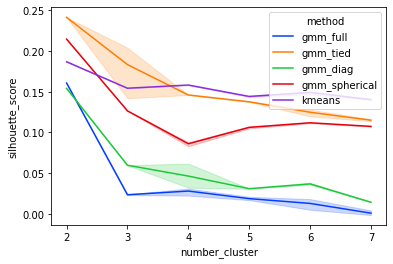

In [ ]:
sns.lineplot(data=df_results, x='number_cluster', y='silhouette_score', hue='method', palette='bright') # Close to 1

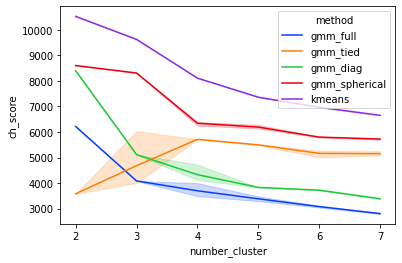

In [ ]:
sns.lineplot(data=df_results, x='number_cluster', y='ch_score', hue='method', palette='bright') # Maximize

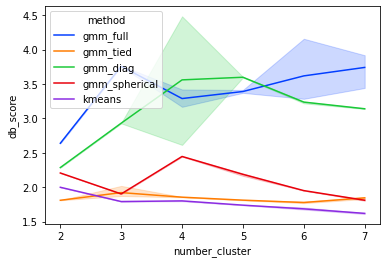

In [ ]:
sns.lineplot(data=df_results, x='number_cluster', y='db_score', hue='method', palette='bright') # close to zero

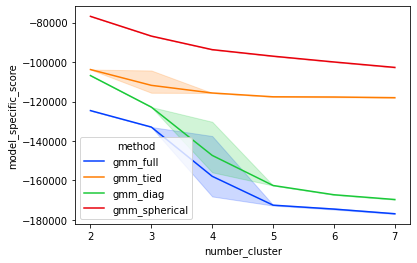

In [ ]:
sns.lineplot(data=df_results[df_results['method']!='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # BIC - Minimize / find elbow

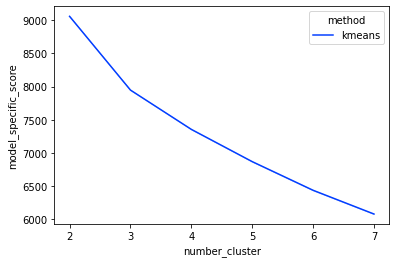

In [ ]:
sns.lineplot(data=df_results[df_results['method']=='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # Find elbow

In [ ]:
break

# Test Rand Score

In [ ]:
#dict_rand_scores[iteration][number_cluster] - avg_rand_score

In [ ]:
# Create empty dict
dict_rand_scores = {}
for i in np.arange(n_iterations):
  dict_temp = {}
  for n_cluster in list_n_cluster:
    dict_temp.update({n_cluster: np.nan})
  dict_rand_scores.update({i: dict_temp})
dict_rand_scores

{0: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 1: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 2: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan}}

In [ ]:
# Calc Rand Scores
for i in np.arange(n_iterations):
  random_seed = random_seeds[i]
  for n_cluster in list_n_cluster:
    cum_rand_scores = 0
    for method_1 in methods:
      df_1 = pd.read_csv('data/clustering/experiments/random_seed_' + str(random_seed) + '/' + method_1 +'_' + str(n_cluster) + '.csv')
      labels_1 = df_1['group'].to_numpy()
      for method_2 in methods:
        df_2 = pd.read_csv('data/clustering/experiments/random_seed_' + str(random_seed) + '/' + method_2 +'_' + str(n_cluster) + '.csv')
        labels_2 = df_2['group'].to_numpy()
        rand_score = metrics.adjusted_rand_score(labels_1, labels_2)
        
        #print(str(n_cluster) + ' Cluster - Comparing ' + method_1 + ' with ' + method_2 + ' - Rand Score: ' + str(rand_score))
        cum_rand_scores = cum_rand_scores + rand_score
    avg_rand_score = (cum_rand_scores-len(methods)) / ((len(methods)-1)*len(methods))
    dict_rand_scores[i][n_cluster] = avg_rand_score
    print(str(n_cluster) + ' Cluster with average rand score: ' + str(avg_rand_score))

2 Cluster with average rand score: 0.3033911473814908
3 Cluster with average rand score: 0.2206134807342071
4 Cluster with average rand score: 0.25732103373702364
5 Cluster with average rand score: 0.2438064957156217
6 Cluster with average rand score: 0.2510634704029074
7 Cluster with average rand score: 0.2628985614551323
2 Cluster with average rand score: 0.3032049598252641
3 Cluster with average rand score: 0.2649939881520053
4 Cluster with average rand score: 0.24955698910902074
5 Cluster with average rand score: 0.24076333949510476
6 Cluster with average rand score: 0.27022858704855607
7 Cluster with average rand score: 0.25805005834158373
2 Cluster with average rand score: 0.30331102244302943
3 Cluster with average rand score: 0.2201710818394366
4 Cluster with average rand score: 0.2250514289664455
5 Cluster with average rand score: 0.2419126661190875
6 Cluster with average rand score: 0.2601888773469351
7 Cluster with average rand score: 0.27229329576407324


In [ ]:
# Create DataFrames
df_rand_scores = pd.DataFrame.from_dict(dict_rand_scores)
df_rand_scores['n_cluster'] = df_rand_scores.index
df_rand_scores_plot = pd.melt(df_rand_scores, id_vars='n_cluster')
df_rand_scores_plot.rename(columns={'variable': 'iteration', 'value': 'rand_score'}, inplace=True)
for i in np.arange(n_iterations):
  df_rand_scores.rename(columns={i: 'rand_score_' + str(i)}, inplace=True)
df_rand_scores['avg_rand_score'] = pd.DataFrame.from_dict(dict_rand_scores, orient='index').mean()
df_rand_scores['std_rand_score'] = pd.DataFrame.from_dict(dict_rand_scores, orient='index').std()
df_rand_scores

,rand_score_0,rand_score_1,rand_score_2,n_cluster,avg_rand_score,std_rand_score
2,0.303391,0.303205,0.303311,2,0.303302,0.000093
3,0.220613,0.264994,0.220171,3,0.235260,0.025752
4,0.257321,0.249557,0.225051,4,0.243976,0.016843
5,0.243806,0.240763,0.241913,5,0.242161,0.001537
6,0.251063,0.270229,0.260189,6,0.260494,0.009586
7,0.262899,0.258050,0.272293,7,0.264414,0.007242


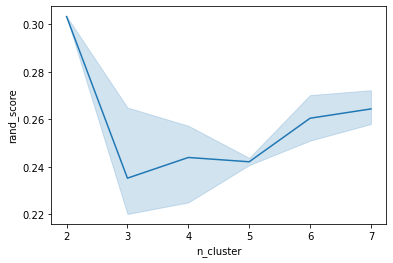

In [ ]:
sns.lineplot(data=df_rand_scores_plot, x='n_cluster', y='rand_score', palette='bright')